In [ ]:
# | hide
%load_ext autoreload
%autoreload 2

# Eval - simplifying agent versioning and evaluation

Note: Eval is still in early development

## Overview


overview of need
- understanding how prompt/param/configuration affect workflow throughout different steps
- it is not enough to write expectations for output
- it is too verbose to write expectations for each node
- defining similarity between output and expectations varies case by case
- in highly parallel workflows, it is hard to know which trace will arive before another

Overview of features:
- can define expectations a subset of nodes
- and a subset of their keys using a simple DSL
- can define partial orderings between expected traces (ie which trace should arrive before another, and when does the order not matter)
- easy definition of custom similarity metrics
- automated away boiler plate in comparing different versions of an agent, finding the traces that changed and inspecting how they changed


Concepts:
- tracelog
- TestCase
  - nodes
  - conditions
- TestSet
- Comparisons



## Testing a single workflow

### Basic Flow

In [ ]:
from stringdale.core import get_git_root
from stringdale.eval import eval, eval_single
from stringdale.examples.react import ReactAgent

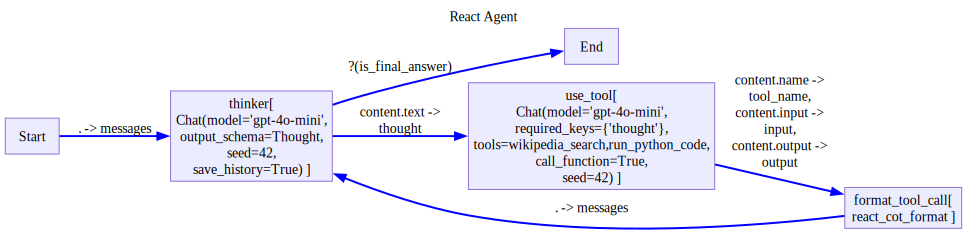

In [ ]:
ReactAgent.draw()

In [ ]:
obama_test_case = get_git_root()/'sample_data'/'eval'/'obama.yaml'
! cat {obama_test_case}

inputs:
  - [{"role":"user","content":"Question: what is obamas age to the power of 2?"}]
test_nodes:
  - name: use_tool
    conditions:
      - key: content.name
        value: "wikipedia_search"
        func: "eq"
      - key: content.input.q
        value: "Obama"
  - name: use_tool
    conditions:
      - key: content.name
        value: run_python_code
        func: eq
      - key: content.output
        value: "({0} < 4000) & ({0} > 3000)"
        func: "eval"


  

In [ ]:
df,log_path = await eval_single(ReactAgent,obama_test_case)
log_path.relative_to(get_git_root())

PosixPath('sample_data/eval/obama.jsonl')

In [ ]:
df

,datapoint,node_label,trace_idx,func,key,actual,expected,distance,node_idx,trace_name,node_name,kwargs,aggregation,comp_id
0,anonymous,0,1,eq,content.name,wikipedia_search,wikipedia_search,0.00000,0,use_tool,use_tool,{},None,0
1,anonymous,0,1,None,content.input.q,Barack Obama,Obama,0.32372,0,use_tool,use_tool,{},None,1
2,anonymous,1,7,eq,content.name,run_python_code,run_python_code,0.00000,1,use_tool,use_tool,{},None,2
3,anonymous,1,7,eval,content.output,3844,({0} < 4000) & ({0} > 3000),0.00000,1,use_tool,use_tool,{},None,3


In [ ]:
# TODO walk through the res

## Available Eval Functions



Stringdale provides several built-in evaluation functions for comparing outputs with expected values. Each function returns a distance score where:
- 0 indicates a perfect match
- Higher values indicate greater differences
- `np.inf` indicates a mismatch


In [ ]:
#| hide
from stringdale.eval import EVAL_FUNCS
from stringdale.doc import show_doc

In [ ]:
#| hide
for k,v in EVAL_FUNCS.items():
    show_doc(v)

#TODO, fix the show_doc to work with all other sections as well
# specifically examples


### eq

<p align="right"> <a href="None">source</a> </p>

> **Signature:** `eq(a, b)`

Compare two values for exact equality.


| Parameter | Type | Default | Description |
|-----------|------|---------|-------------|
| a | None | None | First value to compare |
| b | None | None | Second value to compare |
| :Returns: | float | - | Returns 0 if values are equal, infinity if they differ |




### safe_eval

<p align="right"> <a href="None">source</a> </p>

> **Signature:** `safe_eval(out, expression)`

Safely evaluate a Python expression with a provided value.

This function takes a value and a Python expression template, formats the expression
with the value, and evaluates it safely. It handles various error cases and type
conversions.

| Parameter | Type | Default | Description |
|-----------|------|---------|-------------|
| out | None | None | Value to insert into the expression template |
| expression | str | None | Python expression template with {} placeholder for the value |
| :Returns: | float | - | - For boolean results: 0 if True, infinity if False<br>- For float results: the float value directly<br>- For errors or invalid types: infinity |




### chat_eval

<p align="right"> <a href="None">source</a> </p>

> **Signature:** `chat_eval(out: Any, expected: Any, model: str = 'gpt-4o-mini', system_prompt: str = None) -> float`

Evaluate similarity between two values using a language model.

This function uses a language model to compare two values and return a similarity score.
It can use either a default system prompt or a custom one to guide the evaluation.

| Parameter | Type | Default | Description |
|-----------|------|---------|-------------|
| out | typing.Any | None | First value to compare |
| expected | typing.Any | None | Second value to compare |
| model | <class 'str'> | gpt-4o-mini | Language model to use. Defaults to "gpt-4o-mini" |
| system_prompt | <class 'str'> | None | Custom system prompt for evaluation. Must contain{{out}} and {{expected}} jinja variables. If None, uses default prompt.         |
| :Returns: | <class 'float'> | - | Similarity score between 0 and 1, where:<br>- 0 indicates lowest similarity<br>- 1 indicates highest similarity |




### cosine_dist

<p align="right"> <a href="None">source</a> </p>

> **Signature:** `cosine_dist(out: str, expected: str, model: str = 'text-embedding-3-small') -> float`

Compute cosine distance between two strings using OpenAI embeddings.

This function converts two strings into embeddings using OpenAI's embedding model
and computes the cosine distance between them. The distance is normalized by the norm of the expected embedding.

| Parameter | Type | Default | Description |
|-----------|------|---------|-------------|
| out | <class 'str'> | None | First string to compare |
| expected | <class 'str'> | None | Second string to compare |
| model | <class 'str'> | text-embedding-3-small | OpenAI embedding model to use. Defaults to 'text-embedding-3-small' |
| :Returns: | <class 'float'> | - | Cosine distance between the strings<br>If out is not a string, returns inf |




### eval_any

<p align="right"> <a href="None">source</a> </p>

> **Signature:** `eval_any(out: Any, expected: Any) -> float`

Accept any value by always returning 0 distance.

This function is used to verify the existence of a key or value without
caring about its actual content. It always returns 0, indicating a perfect match
regardless of the input values.

| Parameter | Type | Default | Description |
|-----------|------|---------|-------------|
| out | typing.Any | None | First value (ignored) |
| expected | typing.Any | None | Second value (ignored) |
| :Returns: | <class 'float'> | - | Always returns 0, indicating a perfect match |



## Adding your own Eval functions

An eval function is a function (sync or async) that expects:
* The first positional output to be the result from the agent
* The second positional output to be the expected output from the TestCase
* Any number of kwargs

In [ ]:
import math
import numpy as np

In [ ]:
def word_count(out:str,expected:int,abs=True):
    if not isinstance(out,str):
        return np.inf
    if abs:
        return math.abs(len(out.split()) - expected)
    else:
        return len(out.split()) - expected


To add your own custom eval functions:

In [ ]:
_ = await eval_single(ReactAgent,obama_test_case,
    # pass additional custom eval functions as a dict
    eval_funcs={'word_count':word_count},
    # you can also override which eval function is used by default
    # by passing the `default_eval_func` kwarg the name of the function
    # default_func='word_count'
    )

The default eval function is used when you don't specify an eval function for a given node.
Are:

In [ ]:
{k:v.__name__ for k,v in EVAL_FUNCS.items()}

{'eq': 'eq',
 'eval': 'safe_eval',
 'chat_eval': 'chat_eval',
 'cosine_dist': 'cosine_dist',
 'any': 'eval_any'}

## Workflow Versioning

### Making our agent configurable

In [ ]:
#Rag example


In [ ]:
from stringdale.examples.rag import Rag
from stringdale.db import ChromaClient
from pathlib import Path
import tempfile
import yaml

In [ ]:
dataset_dir = get_git_root()/'sample_data'/'eval_datasets'
test_case_dir = dataset_dir/'test_cases'
agent_config_dir = dataset_dir/'agent_configs'
! tree {agent_config_dir} --noreport | tail -n +2

├── v001
│   ├── agent.yml
│   └── vec_db.yml
├── v002
│   ├── agent.yml
│   └── vec_db.yml
└── v003
    ├── agent.yml
    └── vec_db.yml


In [ ]:
def load_agent(conf_dir: Path):
    agent_yaml_path = conf_dir / 'agent.yml'
    vec_db_yaml_path = conf_dir / 'vec_db.yml'

    agent_conf = yaml.safe_load(agent_yaml_path.read_text())
    vec_db_conf = yaml.safe_load(vec_db_yaml_path.read_text())

    db = ChromaClient(persist_path=tempfile.mkdtemp())
    for collection_name, docs in vec_db_conf.items():
        db.add_collection(collection_name, exists_ok=True)
        db.upsert(collection_name, docs)

    agent_conf['db'] = db
    
    Agent = Rag(**agent_conf)

    return Agent

### Comparing versions

In [ ]:
versions = sorted([p.name for p in agent_config_dir.ls()])
agents = {
    version:load_agent(agent_config_dir/version)
    for version in versions
}
agents

{'v001': <stringdale.base.DiagramSchema RAG Agent @0x11ea6f0e0>,
 'v002': <stringdale.base.DiagramSchema RAG Agent @0x11ea74980>,
 'v003': <stringdale.base.DiagramSchema RAG Agent @0x11ea6e3f0>}

In [ ]:
eval_res = await eval(
    test_dir=test_case_dir,
    agents=agents,
    out_dir=dataset_dir/'eval_results',
    base_agent='v001',
)

Summary of runs:                                                                                                   
    v001                                                                                                           
    Dist: 0.80 AvgDist: 0.61 Coverage: 0.75                                                                        
    v002                                                                                                           
    Dist: 0.81 AvgDist: 0.63 Coverage: 0.75                                                                        
    v003                                                                                                           
    Dist: 0.60 AvgDist: 0.41 Coverage: 0.75                                                                        
Summary of comparisons:                                                                                            
    v001 vs v002:                                                                                                  
      improved (#1): goldens(0.04),                                                                                
      regressed (#1): pikachus(-0.07),                                                                             
    v001 vs v003:                                                                                                  
      improved (#2): pikachus(0.38), goldens(0.03),                                                                
Datapoints:                                                                                                        
    pikachus - ../../../sample_data/eval_datasets/test_cases/pikachus.yaml                                         
      summary:                                                                                                     
        v001 - Dist: 0.83 AvgDist: 0.83 Coverage: 0.50                                                             
        v002 - Dist: 0.90 AvgDist: 0.90 Coverage: 0.50                                                             
        v003 - Dist: 0.44 AvgDist: 0.44 Coverage: 0.50                                                             
        v001 vs v002: Alignment change: False Score change: regressed Score by: -0.07                              
        v001 vs v003: Alignment change: False Score change: improved Score by: 0.38                                
      logs:                                                                                                        
        v001 - ../../../sample_data/eval_datasets/eval_results/runs/v001/logs/pikachus.jsonl                       
        v002 - ../../../sample_data/eval_datasets/eval_results/runs/v002/logs/pikachus.jsonl                       
        v003 - ../../../sample_data/eval_datasets/eval_results/runs/v003/logs/pikachus.jsonl                       
      details:                                                                                                     
        Comparison #0, node_pattern: chat, key: content, func:                                                     
        expected:                                                                                                  
            They are:                                                                                              
              * dangerous                                                                                          
              * smoke cigarettes                                                                                   
                                                                                                                   
        v001 - matched chat(#1):                                                                                   
            Pikachus are not dogs; they are fictional creatures from the Pokémon franchise. They are known for     
            their yellow fur, long ears, and ability to 

In [ ]:
# show different pprint options
# show all dataframes that can be used to inspect the results

In [ ]:
# TODO figure out why v002 didnt output markdown

## Complex trace dependencies

In [ ]:
# TODO sometimes we have parallel traces, and we can't determine which trace should arrive first

In [ ]:
from stringdale import Define,V,E, Condition
from stringdale.chat import Chat

In [ ]:
Define?

Signature:
Define(
    diagram_name,
    type: str = 'flow',
    state: Optional[pydantic.main.BaseModel] = None,
    validate: bool = True,
)
Docstring:
Define a new diagram using a context manager.

Args:
    diagram_name: Name for the new diagram
    type: The type of diagram to create, either 'flow' or 'decision'. Defaults to 'flow'
    state: The state class to use for the diagram. Defaults to BaseModelExtra
    validate: If True, validates diagram structure after definition. Defaults to True
    
Yields:
    The created diagram object
    
Raises:
    ValueError: If diagram_name already exists and solve_name_conflicts is False
File:      ~/dl/stringdale/stringdale/declerative.py
Type:      function

In [ ]:
Chat?

Init signature:
Chat(
    model: Optional[str] = None,
    messages: Optional[List[Dict[str, str]]] = None,
    output_schema: Optional[pydantic.main.BaseModel] = None,
    as_json: Optional[bool] = False,
    tools: Optional[Dict[str, Callable]] = None,
    call_function: Optional[bool] = False,
    choices: Optional[enum.Enum] = None,
    multi_choice: Optional[bool] = False,
    seed: Optional[int] = 42,
    stop: Union[str, List[str], NoneType] = None,
    log_prompt: bool = False,
    save_history: bool = False,
    append_output: bool = False,
    init_messages: Optional[List[Dict[str, str]]] = None,
    **kwargs,
)
Docstring:     
A Chat objects the renders a prompt and calls an LLM. Currently supporting openai models.

Args:
    model: OpenAI model name
    messages: List of message dicts, must have at least a role and content field
    output_schema: Optional schema for structured output
    as_json: Optional boolean to return the response as a json object
    tools: Optional 

In [ ]:
Condition?

Init signature:
Condition(
    func: Union[Callable, str],
    mapping: Optional[str] = None,
    name: Optional[str] = None,
)
Docstring:     
A utility function for creating condition functions using stringdale's port mapping logic.

Args:
    func: A function or string to match against the input. If string, it will be interpreted as a regex pattern to match the input against.
    mapping: A mapping of the input to the function. by default, the input is the first argument of the function.
    name: A name for the condition. by default, is func_name->mapping_string
File:           ~/dl/stringdale/stringdale/utils.py
Type:           type
Subclasses:     

In [ ]:
def MOE_Factory(model:str,experts,expert_selector_prompt, synthesizer_prompt):
    """
    model: the model to use for the MOE
    experts: a dictionary of the form {
        expert_name: {
            description: str,
            agent: Agent,
        }}
        The agent will be passes the input through the `input` jinja variable
    expert_selector_prompt: the prompt to use for the expert selector
        can access experts through the experts jinja variable
    synthesizer_prompt: the prompt to use for the synthesizer
        can access experts outputs through the outputs jinja variable
    """

    expert_selector = Chat(model=model,
        messages=[{"role": "system", "content": expert_selector_prompt}],
        choices=list(experts.keys()),
        multi_choice=True,
        experts = experts
    )

    synthesizer = Chat(model=model,
        messages=[{"role": "system", "content": synthesizer_prompt}],
    )

    with Define("Dynamic Expert",type='decision') as DynamicExpert:
        E('Start->state/choice(0=choice)')
        for expert_name in experts:
            V(expert_name,experts[expert_name]['agent'],
                outputs = ['End(output=.)'])
            E(f'Start->{expert_name}(input=input)',
                cond = Condition(expert_name, '0=choice', name=f'{expert_name}_choice')
                )
        E('state/choice->End(choice=.)')

    with Define("Moe") as Schema:
        V('select_experts',expert_selector,
            inputs = ['Start(input=.)'])
        V('experts',DynamicExpert,
            inputs = [
                'select_experts(choice=content)',
                'Start(input=.)'
                ],
            for_each = ['choice'],
            )
        V('synthesize',synthesizer,
            inputs = ['experts(outputs=.)', 'Start(input=.)'],
            outputs = ['End']
            )

    return Schema
            

In [ ]:
Moe = MOE_Factory(model='gpt-4o-mini',
    experts={
        'biology': {
            'description': 'This expert is an expert in biology',
            'agent': Chat(model='gpt-4o-mini',
                messages=[
                    {"role": "system", "content": "You are an expert in biology. You really really like biology."},
                    {"role": "user", "content": "{{input}}"}
                ],
            )
        },
        'chemistry': {
            'description': 'This expert is an expert in chemistry',
            'agent': Chat(model='gpt-4o-mini',
                messages=[
                    {"role": "system", "content": "You are an expert in chemistry. You really really like chemistry."},
                    {"role": "user", "content": "{{input}}"}
                ],
            )
        },
        'humor': {
            'description': 'This expert is an expert in humor',
            'agent': Chat(model='gpt-4o-mini',
                messages=[{"role": "system", "content": "You are an expert in humor. You like to make fun of people's questions."},
                    {"role": "user", "content": "{{input}}"}
                ],
            )
        }
    },
    expert_selector_prompt='''
    You are a manager of assistants.
    You are given a question and you need to decide which assistants to ask to answer the question.
    You can and should use multiple assistants

    The assistants you can use are:
    {% for expert in experts %}
    - {{expert}}: {{experts[expert]['description']}}
    {% endfor %}

    The question is:
    {{input}}
    ''',
    synthesizer_prompt='''
    You are a synthesizer.
    You take answers from multiple experts and synthesize them into a single answer.
    If the experts have differing opinions, you should present the common aspects of their opinions and also the differences.

    For the question:
    {{input}}
    The experts have given the following answers:
    {% for output in outputs %}
    - {{output['choice']}}: {{output['content']}}
    {% endfor %}
    ''',
    )

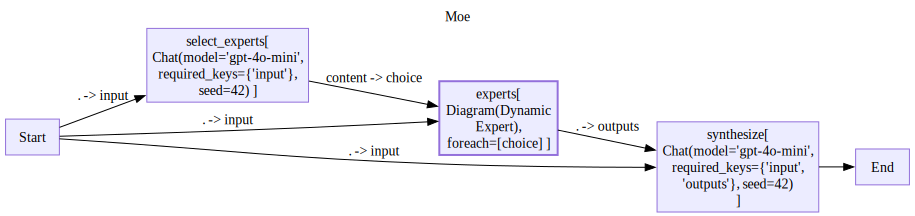

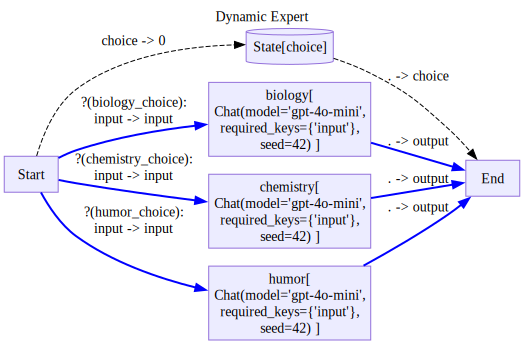

In [ ]:
Moe.draw(recursive=True)

In [ ]:
res,_ = await eval_single(Moe,get_git_root()/'sample_data'/'eval'/'moe.yaml')
res
# TODO from here, this should not work due to timing constraints
# make a unit test in event streaming to replicate this error.

,datapoint,node_label,trace_idx,func,key,actual,expected,distance,node_idx,trace_name,node_name,kwargs,aggregation,comp_id
0,anonymous,0,3,chat_eval,content,"Fun is subjective, but chemistry offers exciti...",experiments,0.0,0,experts[1].chemistry,.*chemistry,{'system_prompt': 'Give a score to the documen...,None,0
1,anonymous,1,0,eval,content,"[biology, chemistry, humor]",res = {}\n'biology' in res and 'chemistry' in ...,0.0,1,select_experts,select_experts,{},None,1
2,anonymous,1,0,eval,content,"[biology, chemistry, humor]",res = {}\n0.5 if 'humor' in res else 0\n,0.5,1,select_experts,select_experts,{},None,2
3,anonymous,2,1,chat_eval,content,"Fun is subjective, but biology often appeals t...",ecosystems,0.5,2,experts[0].biology,.*biology,{'system_prompt': 'Give a score to the documen...,None,3


In [ ]:
from stringdale.eval import safe_eval

In [ ]:
safe_eval(['biology','chemistry'],"""
'biology' in content and 'chemistry' in content'
""")

inf

In [ ]:
# TODO from here, try to instantiate MOE with some chats with simple prompts

# synthesizer example
# show paraller true,
# before and after using label


## Debugging test cases

In [ ]:
from stringdale.eval import eval_single, validate_test_case

In [ ]:
"""

# Debugging

- eval single
- validate endpoints

In the end:

- Explaining lazy eval (how to avoid too many llm calls when evaling)

- Limiting concurrent calls with Semaphores

- Train and Tests sets, checking for overfitting

- Eval behind the scenes
  - Event streaming algorithm
 
- Refernce
  - all end points
- all eval functions

- TestCase Schema

"""

'\n\n# Debugging\n\n- eval single\n- validate endpoints\n\nIn the end:\n\n- Explaining lazy eval (how to avoid too many llm calls when evaling)\n\n- Limiting concurrent calls with Semaphores\n\n- Train and Tests sets, checking for overfitting\n\n- Eval behind the scenes\n  - Event streaming algorithm\n\n- Refernce\n  - all end points\n- all eval functions\n\n- TestCase Schema\n\n'